# Gradientes-conjugados não-lineares com critério de Armijo aplicado à função geofísica

Algoritmo de Gradientes-conjugados não-lineares com método da secante aplicado a um problema geofísico para estimar o raio e o topo de um prisma de base poligonal próximo de um cilindro.

# Importando pacotes

In [57]:
import numpy as np
import matplotlib.pyplot as plt
import cPickle as pickle
from visual import histeq
from fatiando import utils
from fatiando.mesher import PolygonalPrism
from IPython.display import Image as img
from fatiando.gravmag import polyprism
from copy import deepcopy
from fatiando.vis import myv
from fatiando.gridder import regular

# Funções para o prisma de base polygonal do fatiando

In [58]:
def pol2cart(l, M, L):
    '''
    This function transforms polar coordinates of the prisms
    into Cartesian coordinates and returns a list of polygonal
    prisms of the Fatiando a Terra.

    input

    l: list - each element is a list of [r, x0, y0, z1, z2, 'magnetization'],
              whrere r is an array with the radial distances of the vertices,
              x0 and y0 are the origin cartesian coordinates of each prism,
              z1 and z2 are the top and bottom of each prism and
              magnetization is physical property
    M: int - number of vertices per prism
    L: int - number of prisms

    output

    mk: list - list of objects of the class
    fatiando.mesher.PolygonalPrism
    '''

    lk = []
    r = np.zeros(M)  # it contains radial distances of the vertices in polar coordinates
    verts = [] # it contains radial distances of the vertices in Cartesian coordinates

    assert len(l) == L, 'The size of m and the number of prisms must be equal'

    for lv in l:
        assert len(lv[0]) == M, 'All prisms must have M vertices'

    ang = 2*np.pi/M # angle between two vertices

    for lv in l:
        r = lv[0]
        verts=[]
        for i in range(M):
            verts.append([r[i]*np.cos(i*ang) + lv[1], r[i]*np.sin(i*ang) + lv[2]])
        lk.append(PolygonalPrism(verts, lv[3], lv[4], lv[5]))

    return lk

def param2polyprism(m, M, L, z0, dz, props):
    '''
    Returns a lis of objects of the class
    fatiando.mesher.PolygonalPrism

    input

    m: 1D array - parameter vector
    M: int - number of vertices
    L: int - number of prisms
    z0: float - top of the model
    dz: float - thickness of each prism
    props: dictionary - physical property

    output

    mv: list - list of fatiando.mesher.PolygonalPrism
    '''
    P = L*(M + 2)
    assert m.size == P, 'The size of m must be equal to L*(M + 2)'
    for i in range(P):
        assert m[i:i+M].all >= 0., 'The radial distances must be positives'

    r = np.zeros(M) # vector for radial distances
    mv = [] # list of prisms

    k = 0.
    for i in range(0, P, M + 2):
        r = m[i:M+i]
        mv.append([r, m[i+M], m[i+M+1], z0 + dz*k, z0 + dz*(k + 1.), props])
        k = k + 1.

    mv = pol2cart(mv, M, L)

    return mv

# Modelagem direta

In [59]:
M = 10 # number of vertices per prism
L = 1 # number of prisms
P = L*(M+2) # number of parameters

z0_true = 100.    # depth of the top the shallowest prism
dz = 500.    # thickness of each prism

inc = -60.  # inclination
dec = 50.   # declination
intensity = 0.035 # intensity

props={'magnetization': utils.ang2vec(intensity, inc, dec)} # physical property: magnetization

r_true = 500.

r = np.zeros(M) + r_true # radial distance for each vertice

# Cartesian coordinates of the origin of each prism
x0 = 0. 
y0 = 0.

l = [[r, x0, y0, z0_true, z0_true + dz, props]]   # list of parameters of the prisms

# criando os prismas do fatiando
prisms = pol2cart(l, M, L)

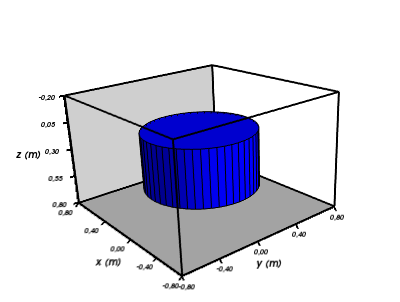

In [60]:
img(filename='bolacha.png')

# Pontos de observação

In [61]:
area = [-2000, 2000, -2000, 2000] #x minimum, x maximum, y minimum and y maximum
shape = (50,50) #number of data along the y and x directions
N = shape[0]*shape[1] #total number of data

#coordinates x and y of the data
xp, yp = regular(area, shape)

zp = np.zeros(N) - 100.

# Dados observados

In [62]:
data = polyprism.tf(xp, yp, zp, prisms, inc, dec) # predict data
amp_noise = 0.01*np.max(data)
data_noise = data + np.random.normal(loc=0., scale=amp_noise, size=shape[0]*shape[1]) # noise corrupted data

In [63]:
# Plot função desajuste

In [64]:
r_plot = np.linspace(10., 1000., 10)
z0_plot = np.linspace(-100., 500., 10)
r_plot,z0_plot = np.meshgrid(r_plot, z0_plot)
r_plot = r_plot.ravel()
z0_plot = z0_plot.ravel()
phi_plot = np.zeros_like(r_plot)

for i, (r, z) in enumerate(zip(r_plot,z0_plot)):
    m = np.zeros(M) + r
    m = np.hstack((m,np.zeros(2)))
    l = param2polyprism(m, M, L, z, dz, props)
    d_pred = polyprism.tf(xp, yp, zp, l, inc, dec)
    phi_plot[i] = np.sum((data - d_pred)**2)

r_plot = r_plot.reshape((20,20))
z0_plot = z0_plot.reshape((20,20))
phi_plot = phi_plot.reshape((20,20))

# equalizando as cores
phi_eq = histeq(phi_plot)
phi_eq = np.reshape(phi_eq,(20,20))
phi_eq = phi_eq

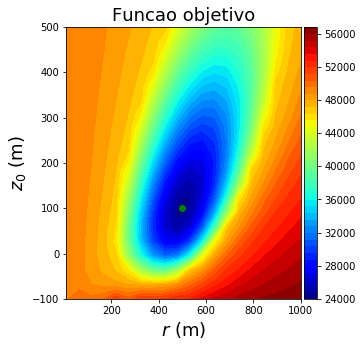

In [65]:
plt.figure(figsize=(5,5))
plt.plot(r_true, z0_true, 'og')
plt.title('Funcao objetivo', fontsize=18)
plt.contourf(r_plot, z0_plot, phi_eq, 50, cmap='jet')
plt.xlabel('$r$ (m)', fontsize=18)
plt.ylabel('$z_0$ (m)', fontsize=18)
plt.colorbar(pad=0.01, aspect=20, shrink=1)
plt.show()

# Funções

In [66]:
def derivative_tf_z0(xp, yp, zp, prism, M, deltaz, inc, dec):
    '''
    This function calculates the derivative for total field anomaly
    from a model of polygonal prisms using finite difference.

    input

    xp: array - x observation points
    yp: array - y observation points
    zp: array - z observation points
    prism: list - list of one fatiando.mesher.PolygonalPrism
    M: int - number of vertices per prism
    delta: float - increment in x coordinate in meters
    inc: float - inclination
    dec: declination

    output

    df1: 1D array - derivative plus
    df2: 1D array - derivative minus
    '''
    assert xp.size == yp.size == zp.size, 'The number of points in x, y and z must be equal'

    prism_plus = deepcopy([prism])  # m.x + delta
    prism_minus = deepcopy([prism])  # m.x - deltaa
    prism_plus[0].z1 += deltaz
    prism_minus[0].z1 -= deltaz

    df1 = polyprism.tf(xp, yp, zp, prism_plus, inc, dec)
    df2 = polyprism.tf(xp, yp, zp, prism_minus, inc, dec)

    return df1, df2

def derivative_tf_radiall(xp, yp, zp, prism, M, deltar, inc, dec):
    '''
    This function calculates the derivative for total field anomaly
    from a model of polygonal prisms using finite difference.

    input

    xp: array - x observation points
    yp: array - y observation points
    zp: array - z observation points
    prism: list - list of a fatiando.mesher.PolygonalPrism
    M: int - number of vertices per prism
    deltar: float - increment in radial distance in meters
    inc: float - inclination
    dec: declination

    output

    df1: 1D array - derivative plus
    df2: 1D array - derivative minus
    '''
    assert xp.size == yp.size == zp.size, 'The number of points in x, y and z must be equal'
    
    ang = 2.*np.pi/M # angle between two vertices
    
    prism_plus = deepcopy([prism])  # m.x + delta
    prism_minus = deepcopy([prism])  # m.x - delta

    for i in range(M):
        deltax = deltar*np.cos(i*ang)
        deltay = deltar*np.sin(i*ang)
        prism_plus[0].x[i] += deltax
        prism_plus[0].y[i] += deltay
        prism_minus[0].x[i] -= deltax
        prism_minus[0].y[i] -= deltay

    df1 = polyprism.tf(xp, yp, zp, prism_plus, inc, dec)
    df2 = polyprism.tf(xp, yp, zp, prism_minus, inc, dec)

    return df1, df2

def grad_geo(xp, yp, zp, prism, M, deltar, deltaz, inc, dec, dobs):
    '''
    Returns the gradient vector for polygonal prisms using finite
    differences.

    input

    xp: array - x observation points
    yp: array - y observation points
    zp: array - z observation points
    prism: list - list of fatiando.mesher.PolygonalPrism
    M: int - number of vertices per prism
    deltar: float - increment in meters for radial distance
    deltaz: float - increment in meters for depth
    inc: float - inclination of the local-geomagnetic field
    dec: float - declination of the local-geomagnetic field
    dobs: 1D array - data vector

    output

    grad: 1D array - gradient
    '''
    assert xp.size == yp.size == zp.size, 'The number of points in x, y and z must be equal'
    
    drp, drm = derivative_tf_radiall(xp, yp, zp, prism[0], M, deltar, inc, dec)
    dzp, dzm = derivative_tf_z0(xp, yp, zp, prism[0], M, deltaz, inc, dec)
    grad = np.zeros(2)
    grad[0] = (np.sum((dobs - drp)*(dobs - drp)) - np.sum((dobs - drm)*(dobs - drm)))/(2.*deltar)
    grad[1] = (np.sum((dobs - dzp)*(dobs - dzp)) - np.sum((dobs - dzm)*(dobs - dzm)))/(2.*deltaz)
    
    return grad

# Modelo interpretativo

In [67]:
# chute inicial
p01 = 900.
p02 = 10.

# incremento para as derivadas
deltar = 0.01*p01
deltaz = 0.01*p02

r = np.zeros(M) + p01 # radial distance for each vertice

# Cartesian coordinates of the origin of each prism
x0 = 0. 
y0 = 0.

l = [[r, x0, y0, p02, dz, props]]

prism0 = pol2cart(l, M, L)

d0 = polyprism.tf(xp, yp, zp, prism0, inc, dec)

# vetor do chute inicial
p0 = np.array([p01,p02]) 

# parâmetros para o método da secante
sigma = 0.0001

# critério de parada
epsilon = 0.00000001

# calculando o valor da função e do resíduo em p0
res0 = data_noise - d0
phi0 = np.sum(res0*res0)

# listas para armazenar as estimativas
p1_list = [p01]
p2_list = [p02]
phi_list = [phi0]

# iterações do algoritmo
itmax = 1000

# calculando a Jacobiana e o gradiente
G0 = jacobi_geo(xp, yp, zp, prism0, M, deltar, deltaz, inc, dec)
grad0 = -2.*np.dot(G0.T, res0)
deltap0 = - grad0

# Algoritmo Gradientes-conjugados não-lineares com método da secante

In [68]:
for i in range(itmax):
    # calculando p e atualizando para a próxima iteração
    p = p0 + sigma*deltap0
    l = [[np.zeros(M) + p[0], x0, y0, p[1], dz, props]]
    prism = pol2cart(l, M, L)
    d = polyprism.tf(xp, yp, zp, prism, inc, dec)
    res = data_noise - d
    G = jacobi_geo(xp, yp, zp, prism, M, deltar, deltaz, inc, dec)
    grads = -2.*np.dot(G.T, res)
    
    while abs(np.sum(grad0*grad0)) > 1e-2:
        # calculando alfa
        alfa = - sigma*(np.sum(grad0*deltap0)/(np.sum(grads*deltap0) - np.sum(grad0*deltap0)))
        p = p0 + alfa*deltap0
        print abs(np.sum(grad0*grad0))
        
        l = [[np.zeros(M) + p[0], x0, y0, p[1], dz, props]]
        prism = pol2cart(l, M, L)
        d = polyprism.tf(xp, yp, zp, prism, inc, dec)
        res = data_noise - d
        G = jacobi_geo(xp, yp, zp, prism, M, deltar, deltaz, inc, dec)
        grad = -2.*np.dot(G.T, res)
        
        beta = np.sum(grad*grad)/np.sum(grad0*grad0)
        print beta
        deltap0 = - grad + beta*deltap0
        
        grad0 = grad.copy()
        p0 = p.copy()
        d0 = d.copy()
        res0 = res.copy()
        phi0 = phi
        prism0 = prism
        
    l = [[np.zeros(M) + p[0], x0, y0, p[1], dz, props]]
    prism = pol2cart(l, M, L)
    d = polyprism.tf(xp, yp, zp, prism, inc, dec)
    res = data_noise - d
    phi = np.sum(res*res)
    
    # printa os valores
    print 'itreação: %3d   lambda: %.2e   r: %3.2f   z_0: %3.2f   misfit: %.2e' % (i, alfa, p[0], p[1], phi)
    
                       
    # armazenando a última estimativa
    phi_list.append(phi)
    p1_list.append(p[0])
    p2_list.append(p[1])
    
    if (abs(phi - phi0)/phi0 <= epsilon):
        break
    else:
        # atualizando parâmetros
        p0 = p.copy()
        d0 = d.copy()
        res0 = res.copy()
        phi0 = phi
        prism0 = prism
        #sigma = - alfa

22926.3819716
0.127684015616
2927.33251369
1.00008967221
2927.59501407
1.0001560903
2928.05198325
1.0002225509
2928.70362385
1.00028907312
2929.55023335
1.00035567637
2930.59220514
1.00042238015
2931.8300291
1.00048920411
2933.26429239
1.00055616801
2934.89568016
1.00062329179
2936.72497653
1.00069059552
2938.75306563
1.00075809948
2940.9809328
1.00082582417
2943.40966592
1.00089379031
2946.04045695
1.00096201889
2948.87460352
1.00103053118
2951.91351075
1.00109934876
2955.15869321
1.00116849355
2958.61177707
1.00123798781
2962.27450239
1.00130785421
2966.14872558
1.00137811583
2970.2364221
1.0014487962
2974.53968934
1.00151991931
2979.06074964
1.00159150967
2983.80195362
1.00166359233
2988.76578366
1.00173619291
2993.95485764
1.00180933766
2999.37193293
1.00188305346
3005.01991062
1.00195736787
3010.90184005
1.0020323092
3017.02092357
1.00210790653
3023.38052168
1.00218418974
3029.9841584
1.00226118959
3036.83552703
1.00233893775
3043.93849627
1.00241746685
3051.2971167
1.00249681057


KeyboardInterrupt: 

# Plots de resultados

In [ ]:
res_norm = (res - np.mean(res))/np.std(res)
res_plot = res.reshape(shape)
xp = xp.reshape(shape)
yp = yp.reshape(shape)
dpred = data.reshape(shape)
dobs = data_noise.reshape(shape)

In [ ]:
#plot
plt.figure(figsize=(5,5))
plt.plot(r_true, z0_true, 'oy')
plt.plot(p1_list, p2_list, '.w-', markersize=5)
plt.title('SD com Armijo - geofisica', fontsize=18)
plt.contourf(r_plot, z0_plot, phi_eq, 40, cmap='jet')
plt.xlabel('$p_1$', fontsize=18)
plt.ylabel('$p_2$', fontsize=18)
plt.colorbar(pad=0.01, aspect=20, shrink=1)
plt.show()

In [ ]:
# plot
plt.figure(figsize=(20,5))
plt.subplot(1, 3, 1)
plt.title('Convergencia', fontsize = 18)
plt.xlabel('Iteration number', fontsize = 18)
plt.plot(phi_list, 'o')

plt.subplot(1, 3, 2)
plt.title('Estimativas de  $r$', fontsize = 18)
plt.xlabel('Iteration number', fontsize = 18)
plt.ylabel('r', fontsize = 18)
plt.plot(p1_list, 'o')
plt.plot(np.zeros(len(p1_list)) + r_true, '-')

plt.subplot(1, 3, 3)
plt.title('Estimativas de  $z_0$', fontsize = 18)
plt.xlabel('Iteration number', fontsize = 18)
plt.ylabel('z0', fontsize = 18)
plt.plot(p2_list, 'o')
plt.plot(np.zeros(len(p1_list)) + z0_true, '-')
plt.show()

In [ ]:
# plot
plt.figure(figsize=(20,5))
plt.subplot(1, 3, 1)
plt.title('Dado predito', fontsize=20)
plt.contourf(yp, xp, dpred, 40, cmap='jet').ax.tick_params(labelsize=12)
plt.xlabel('$y$(m)', fontsize=18)
plt.ylabel('$x$(m)', fontsize=18)
clb = plt.colorbar(pad=0.01, aspect=20, shrink=1)
clb.ax.tick_params(labelsize=13)

plt.subplot(1, 3, 2)
plt.title('Dado observado', fontsize=20)
plt.contourf(yp, xp, dobs, 40, cmap='jet').ax.tick_params(labelsize=12)
plt.xlabel('$y$(m)', fontsize=18)
plt.ylabel('$x$(m)', fontsize=18)
clb = plt.colorbar(pad=0.01, aspect=20, shrink=1)
clb.ax.tick_params(labelsize=13)

plt.subplot(1, 3, 3)
plt.title('SD - ajuste', fontsize=20)
plt.contourf(yp, xp, res_plot, 40, cmap='jet').ax.tick_params(labelsize=12)
plt.xlabel('$y$(m)', fontsize=18)
plt.ylabel('$x$(m)', fontsize=18)
clb = plt.colorbar(pad=0.01, aspect=20, shrink=1)
clb.ax.tick_params(labelsize=13)
plt.show()

In [ ]:
plt.plot(figsize=(20,5))
plt.title('Histogram', fontsize = 20)
plt.xlabel('$\mu$ = %.7f  $\sigma$ = %.7f' % (np.mean(res_norm), np.std(res_norm)), fontsize=20)
nbins = int((np.max(res_norm) - np.min(res_norm)))
plt.hist(res_norm,bins=nbins, normed=True)
plt.ylim(0.,0.5)
plt.xlim(-10., 10.)
plt.show()